In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from datetime import datetime
from numba import jit

import tables
import os

cs137_co60.h5 (File) ''
Last modif.: 'Sun Sep 30 12:17:15 2018'
Object Tree: 
/ (RootGroup) ''
/EventData (Table(83439,), shuffle, zlib(1)) ''
/RawData (EArray(83439, 4096), shuffle, zlib(1)) ''

83439


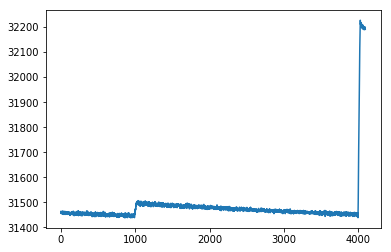

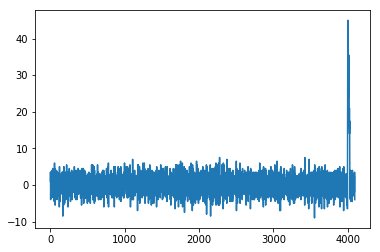

In [48]:
h5file = tables.open_file("cs137_co60.h5", driver="H5FD_CORE")
print(h5file)
data = h5file.root.RawData
EventData = h5file.root.EventData
print(len(EventData))



plt.figure()
plt.plot(data[2422,:])
plt.figure()
plt.plot(np.gradient(data[2422,:]))
plt.show()

In [53]:
# Find pulses that triggered multiple times and delete them
i_pileup = 0
j_pileup = 0
pileup_args = np.array([])
EventDataArray = np.array(EventData)

for x in range(len(EventData)):
    if int(EventData[x][3])>1:
        pileup_args = np.append(pileup_args,i_pileup)
        j_pileup = j_pileup+1  
    i_pileup = i_pileup+1

print(data)
print(len(pileup_args))

data = np.delete(data[:], pileup_args, 0)
    
print('deleted ', len(pileup_args),' signals due to pile up')
print(len(data2))

/RawData (EArray(83439, 4096), shuffle, zlib(1)) ''
999


/Users/DragonKnight/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:16: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  app.launch_new_instance()


deleted  999  signals due to pile up
82440


In [54]:
@jit(parallel = True)
def TrapFilter(mysignal,tau):
    GradSignal = np.gradient(mysignal)
    argPeak = np.argmax(GradSignal)
    avgNoise = np.mean(mysignal[0:argPeak-5])
    newSignal = mysignal - avgNoise
#    
#    @jit(parallel = True)
#    def func(x, a, b):
#        return a * np.exp(-b * x)
#
#    popt, pcov = curve_fit(func, range(0,len(newSignal)-argPeak), newSignal[argPeak:])
#    tau = 1/popt[1]
    
    #signalOnly = newSignal[argPeak:]
    signalOnly = newSignal
    m=40
    #k=int((len(signalOnly)-m)/2)
    #k = peaking time
    #m= Gap time (in samples)
    k=100
    M = tau
    Acc1=0.0
    Acc2=0.0
    l =2*k+m
    final = list(range(len(signalOnly)))
    i=0
    zeros = np.zeros(2*k+m)
    extSignalOnly=np.append(zeros,signalOnly)
    while i < len(signalOnly):
        parta = extSignalOnly[i+(2*k+m)] - extSignalOnly[i-k+(2*k+m)]
        partb = extSignalOnly[i-2*k-m+(2*k+m)] - extSignalOnly[i-k-m+(2*k+m)]
        partc = parta + partb
        Acc1 = Acc1+partc
        partd = partc*M+Acc1
        Acc2 = Acc2 + partd
        final[i] = Acc2
        i=i+1
    
    normFinal = np.array(final)
    #/max(final)
    return normFinal

In [55]:
rows = len(data[:,0])
print(rows)
cols = len(data[0,:])
mysignals = np.zeros((rows,cols))

@jit(parallel = True)
def makesignals(raw_data):
    for j in range(0,rows):
        mysignals[j] = data[j,:]
    return mysignals

startTime = datetime.now()

mysignals = makesignals(data)

print(datetime.now() - startTime)

82440
0:00:07.538734


In [150]:

#tau = np.zeros(events)
#trap_out = np.zeros((events,cols))

@jit(parallel = True)
def eventsProcess(mysignal, events, cols):
    tau = np.zeros(events)
    startTime = datetime.now()
    trap_out = np.zeros((events,cols))
    for j in range(0,events):
        print(j)
        mysignal = mysignals[j,:]
        GradSignal = np.gradient(mysignal)
        argPeak = np.argmax(GradSignal)
        avgNoise = np.mean(mysignal[0:900])
        newSignal = mysignal - avgNoise
    #    plt.figure()
    #    plt.plot(newSignal)

        @jit(parallel = True)
        def func(x, a, b):
            return a * np.exp(-b * x)

        popt, pcov = curve_fit(func, range(0,len(newSignal)-1050), newSignal[1050:])
    #    print(popt)
        tau[j] = 1.0/popt[1]
        trap_out[j] = TrapFilter(mysignals[j,:],6179.29)
    print('Average Tau across all signals',np.mean(tau))
    print(datetime.now() - startTime)
    return trap_out

In [151]:
events = 20000
trap_out = eventsProcess(mysignal, events, cols)

LoweringError: Failed at object (object mode backend)
make_function(name=$const67.38, defaults=None, code=<code object func at 0x1033bea150, file "<ipython-input-150-5e83d8d035a8>", line 20>, closure=None)

File "<ipython-input-150-5e83d8d035a8>", line 20:
def eventsProcess(mysignal, events, cols):
    <source elided>

        @jit(parallel = True)
        ^
[1] During: lowering "$67.39 = make_function(name=$const67.38, defaults=None, code=<code object func at 0x1033bea150, file "<ipython-input-150-5e83d8d035a8>", line 20>, closure=None)" at <ipython-input-150-5e83d8d035a8> (20)
-------------------------------------------------------------------------------
This should not have happened, a problem has occurred in Numba's internals.

Please report the error message and traceback, along with a minimal reproducer
at: https://github.com/numba/numba/issues/new

If more help is needed please feel free to speak to the Numba core developers
directly at: https://gitter.im/numba/numba

Thanks in advance for your help in improving Numba!


4096
1115


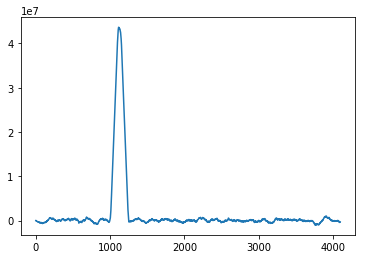

In [129]:
plt.figure()
plt.plot(trap_out[100][:])
print(len(trap_out[0]))
print(np.argmax(trap_out[100][:]))

In [148]:
#from scipy.interpolate import UnivariateSpline
#spline = UnivariateSpline(trap_out[100][:])

In [149]:
#print(len(trap_out[100]))
#print(FWHM(trap_out[100][:],range(len(trap_out[100]))))

In [130]:
counts = []
for j in range(0,len(trap_out)):
    counts = np.append(counts,trap_out[j][1115]))

[6.88858020e+07 5.21815870e+07 4.28599880e+07 ... 1.58655135e+08
 3.36233509e+08 5.77234170e+07]


(array([  4.,   0.,   0.,   0.,   3.,  21.,  28.,  63.,  95., 127., 135.,
        171., 204., 207., 258., 290., 415., 391., 432., 408., 485., 439.,
        453., 410., 445., 433., 411., 391., 378., 371., 345., 362., 328.,
        333., 275., 282., 255., 255., 237., 232., 222., 231., 238., 197.,
        194., 210., 196., 165., 184., 158., 156., 137., 162., 145., 140.,
        123., 124., 134., 101.,  91., 102.,  98.,  88.,  89.,  82.,  86.,
         76.,  74.,  68.,  80.,  66.,  69.,  53.,  55.,  66.,  56.,  73.,
         68.,  76.,  76.,  48.,  41.,  50.,  47.,  48.,  49.,  52.,  45.,
         56.,  38.,  44.,  48.,  35.,  37.,  43.,  47.,  36.,  43.,  25.,
         48.,  33.,  35.,  45.,  36.,  43.,  30.,  41.,  40.,  38.,  24.,
         34.,  27.,  28.,  19.,  33.,  51.,  20.,  22.,  19.,  32.,  24.,
         22.,  21.,  20.,  22.,  16.,  20.,  28.,  20.,  25.,  18.,  40.,
         23.,  20.,  18.,  30.,  14.,  35.,  28.,  19.,  17.,   9.,  20.,
         21.,  20.,  22.,   9.,  21., 

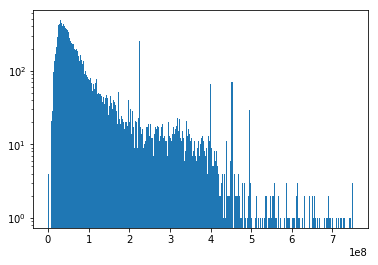

In [135]:
print(np.trim_zeros(counts))
counts2 = np.trim_zeros(counts)
counts3 = counts2[(counts2>0) & (counts2<0.75e9)]
plt.figure()
plt.yscale('log')
plt.hist(counts3,bins=500)